In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from Class_utils.parameters import file_paths,job_graph_par
from Class_utils.JobGraph import JobGraph
import ast
from Class_utils.FitnessFunctions import FitnessFunctions

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [2]:
job_graph = JobGraph(file_paths, **job_graph_par)

Cache found loading...done


In [3]:
offer = pd.read_csv("../outputs/test20k_job_offers.csv").set_index("qId")

In [4]:
offer_md = pd.json_normalize(offer["metadata"].apply(ast.literal_eval))
offer_md.index.rename("qId", inplace=True)

In [5]:
es_comp_columns = ["Competence_essential"+str(i) for i in range(0, 3 + 1)]
op_comp_columns = ["Competence_optional"+str(i) for i in range(0, 2 + 1)]
es_know_columns = ["Knowledge_essential"+str(i) for i in range(0, 3 + 1)]
op_know_columns = ["Knowledge_optional"+str(i) for i in range(0, 2 + 1)]

In [6]:
counter = np.zeros((4,5))
total = np.zeros((4,5))

qId_error_comp_ess,qId_error_comp_opt,qId_error_know_ess,qId_error_know_opt = [],[],[],[]

for qId, job in tqdm(offer.iterrows(),total=len(offer)):

    essential_comp = FitnessFunctions.filter(job[es_comp_columns].to_list())
    optional_comp = FitnessFunctions.filter(job[op_comp_columns].to_list())
    un_es_comp, amb_es_comp = job_graph.skill_standardize(essential_comp)
    un_op_comp, amb_op_comp = job_graph.skill_standardize(optional_comp)
    de_amb_es_comp = job_graph.solve_ambiguous(amb_es_comp, un_es_comp + un_op_comp)
    de_amb_op_comp = job_graph.solve_ambiguous(amb_op_comp, un_es_comp + un_op_comp)

    real_uris = offer_md.loc[qId, "uri_competence_essential"]
    equal_ = 0 if set(un_es_comp) | set(de_amb_es_comp)  ==  set(real_uris) else 1
    total[0,len(amb_es_comp)] +=1
    if equal_ == 1:
        counter[0, len(amb_es_comp)] += 1
        qId_error_comp_ess.append(qId)
    
    real_uris = offer_md.loc[qId, "uri_competence_optional"]
    equal_ = 0 if set(un_op_comp) | set(de_amb_op_comp)  ==  set(real_uris) else 1
    total[1,len(amb_op_comp)] +=1
    if equal_ == 1:
        counter[1, len(amb_op_comp)] += 1
    qId_error_comp_opt.append(qId)
    
    essential_know = FitnessFunctions.filter(job[es_know_columns].to_list())
    optional_know = FitnessFunctions.filter(job[op_know_columns].to_list())
    un_es_know, amb_es_know = job_graph.skill_standardize(essential_know)
    un_op_know, amb_op_know = job_graph.skill_standardize(optional_know)
    de_amb_es_know = job_graph.solve_ambiguous(amb_es_know, un_es_know + un_op_know)
    de_amb_op_know = job_graph.solve_ambiguous(amb_op_know, un_es_know + un_op_know)


    real_uris = offer_md.loc[qId, "uri_knowledge_essential"]
    equal_ = 0 if set(un_es_know) | set(de_amb_es_know)  ==  set(real_uris) else 1
    total[2,len(amb_es_know)] +=1
    if equal_ == 1:
        counter[2, len(amb_es_know)] += 1
        qId_error_know_ess.append(qId)

    real_uris = offer_md.loc[qId, "uri_knowledge_optional"]
    equal_ = 0 if set(un_op_know) | set(de_amb_op_know)  ==  set(real_uris) else 1
    total[3,len(amb_op_know)] +=1
    if equal_ == 1:
        counter[3, len(amb_op_know)] += 1
        qId_error_know_opt.append(qId)
    

100%|██████████| 20000/20000 [00:22<00:00, 872.91it/s]


In [7]:
total_, errors_ = list(total.sum(axis=0)), list(counter.sum(axis=0))
dt = pd.DataFrame(
    {
        "# ambiguous":[*range(len(errors_))],
        "perc": [e/t if t > 0 else 0 for t, e in zip(total_,errors_)],
        "%": [str(format(e/t, '.4f'))+" %" if t > 0 else "0.0000 %" for t, e in zip(total_,errors_)]
    })
dt.drop(0,inplace=True)
dt

,# ambiguous,perc,%
1,1,0.144125,0.1441 %
2,2,0.364486,0.3645 %
3,3,0.666667,0.6667 %
4,4,0.000000,0.0000 %


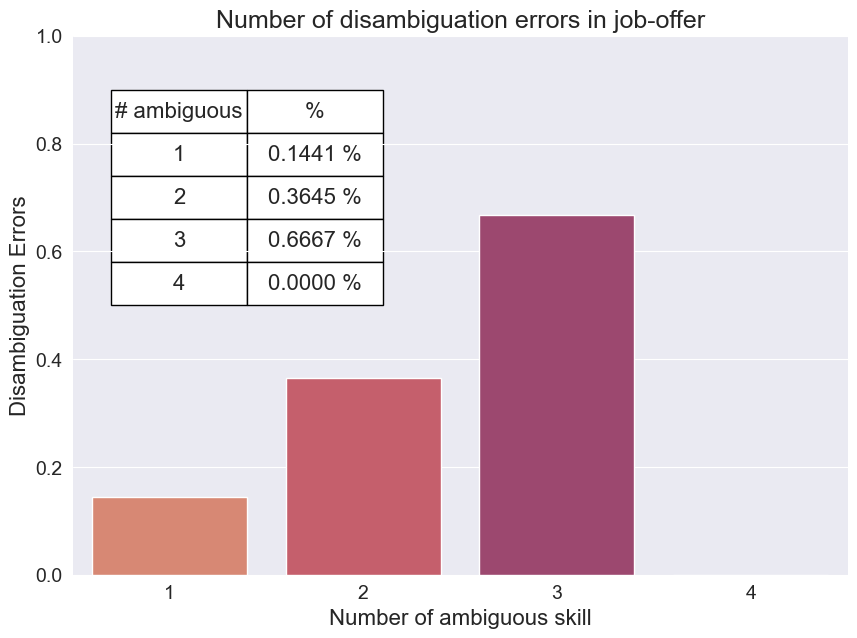

In [8]:
_, axs = plt.subplots(figsize=(10, 7))


sns.barplot(x="# ambiguous", y="perc", data=dt, palette="flare", ax=axs)
sns.despine(left=True, bottom=True)
axs.set_title('Number of disambiguation errors in job-offer', fontsize=18)
axs.set_xlabel('Number of ambiguous skill', fontsize=16)
axs.set_ylabel('Disambiguation Errors', fontsize=16)
axs.tick_params(axis='both', labelsize=14)
axs.set_ylim([0, 1])

table = plt.table(cellText=dt[["# ambiguous","%"]].values, colLabels=dt[["# ambiguous","%"]].columns,
                  cellLoc='center', bbox=[0.05, 0.5, 0.35, 0.4], loc='upper right')

table.auto_set_font_size(False)
table.set_fontsize(16)
plt.show()